# Evaluating Error Bars from Bootstrap Ensembles
We trained an ensemble of models trained with a bootstrapped sample of the full training set. 
Here, we explore if the variance is a good measure of variance

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.benchmark import load_benchmark_data
from jcesr_ml.mpnn import set_custom_objects, run_model
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import norm
from nfp.preprocessing import GraphSequence
from keras.models import load_model
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import shutil
import json
import os

Using TensorFlow backend.
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

Set up the environment

In [2]:
set_custom_objects()

In [3]:
train_data, test_data = load_benchmark_data()

## Build Utility Scripts
Scripts used to assess model performance

In [4]:
model_info = pd.read_csv('mpnn-results.csv')

In [5]:
def load_solv_models(desc):
    """Loads an ensemble of models and associated featurizer
    
    Args:
        desc (dict): Model configuration
    Returns:
        - (Model) Keras model
        - (SmilesPreprocesser) Associated featurizer
        - ([str]) List of model paths
        - ([str]) List of output properties
    """
    
    # Check if network name is in the description
    if 'name' not in desc:
        raise ValueError('`name` must be included in the model configuration')
        
    # Load in the converter
    conv_path = os.path.join('networks', desc['name'], 'converter.pkl')
    with open(conv_path, 'rb') as fp:
        conv = pkl.load(fp)
    
    # Find the desired model
    query = ' and '.join(f'{k}=="{v}"' for k, v in desc.items())
    hits = model_info.query(f'{query} and bootstrap').sort_values('seed')
    print(f'Found {len(hits)} models. Random seeds: {hits.seed.tolist()}')
    if len(hits) == 0:
        raise ValueError(f'No such model for query: {query}')
    model_paths = [os.path.join(p, 'best_model.h5') for p in hits['path']]
    models = [load_model(p) for p in tqdm(model_paths)]
    
    with open(os.path.join(os.path.dirname(model_paths[0]), '..', 'options.json')) as fp:
        output_props = json.load(fp)['output_props']
    
    return models, conv, model_paths, output_props

## Plot the Performance of One Model on a Few Molecules
Just to see what we're working with. Are the predictions smooth and accurate?

In [6]:
models, conv, model_paths, output_props = load_solv_models({
    'name': 'dielectric-constant-softplus-atomic-contrib', 'num_epochs': 4096
})

  0%|                                                                                                  | 0/16 [00:00<?, ?it/s]

Found 16 models. Random seeds: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
100%|█████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:55<00:00, 10.97s/it]


In [7]:
def get_ensemble_estimate(models, conv, mols, batch_size=1024):
    """Predict the solvation energy with an ensemble of models
    
    Args:
        models ([Model]): Solvation energy models
        conv (SmilesPreprocessor): Tool to generate inputs for model
        mols ([str]): List of smiles strings to evaluate
    Returns:
        
    """
    # Turn the molecule into a graph sequence
    g = GraphSequence(list(conv.preprocess(mols, train=False)), batch_size=1024)
    
    # Pipe the sequence through the model
    return np.stack([model.predict(g) for model in tqdm(models)], axis=-1)

In [8]:
y_pred = get_ensemble_estimate(models, conv, test_data['smiles_0'])

100%|█████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:56<00:00, 14.81s/it]


In [9]:
y_pred_mean = np.mean(y_pred, axis=-1)

In [10]:
y_pred_std = np.std(y_pred, axis=-1)

## Make a Plot with the Error Bars
Just to see how they are doing, visually

Text(0, 0.5, '$E_{solv}$, ML (kcal/mol)')

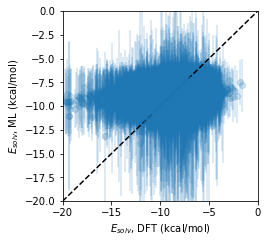

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.errorbar(test_data[output_props[0]], np.mean(y_pred[:, 0, :], axis=-1),
            fmt='o', alpha=0.2, yerr=np.std(y_pred[:, 0, :], axis=-1))

ax.set_xlim(-20, 0)
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('$E_{solv}$, DFT (kcal/mol)')
ax.set_ylabel('$E_{solv}$, ML (kcal/mol)')

Plot the normalized residuals

In [12]:
Z = (y_pred_mean - test_data[output_props].values) / y_pred_std

Text(0, 0.5, 'PDF')

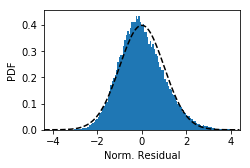

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 2.2))

ax.hist(Z.flatten(), bins=np.linspace(-4, 4, 128), density=True)
ax.set_xlim(ax.get_xlim())

z = np.linspace(*ax.get_xlim(), 128)
ax.plot(z, norm().pdf(z), 'k--')

ax.set_xlabel('Norm. Residual')
ax.set_ylabel('PDF')

*Finding*: Decent fit to a normal distribution

## Save Paths to Models
Make it easy to load in the ensemble later

In [14]:
out_path = 'bootstrapped-models'

In [15]:
if os.path.isdir(out_path):
    shutil.rmtree(out_path)
os.mkdir(out_path)

In [16]:
with open(os.path.join(out_path, 'conv.pkl'), 'wb') as fp:
    pkl.dump(conv, fp)

In [17]:
for i, m in enumerate(model_paths):
    os.symlink(os.path.join('..', m), os.path.join(out_path, f'model_{i}.h5'))